# What's in a Game? Analyzing Trends in Popular Board Games
### Robert Choi, Andrew Walter-McNeill

## Introduction
One of the reasons data mining is such a powerful way to analyze data is that there are so many different classification approaches to chose from. This versatility means that there are likely multiple viable classifiers that can be used to analyze a given data set, and thus multiple ways to address a given problem. However, in order to take full advantage of this versatility, it is necessary to decide which classification approach is best for each data set. In the following project, we explore the relative effectiveness of two classification approaches, decision trees and artificial neural nets, on a data set of popular board games.

One of our group members is a board game hobbyist and was intrigued by the idea of investigating what sort of qualities, if any, tend to make a board game well received. Using decision trees and ANNs, we hope to analyze data collected from BoardGameGeek.com for these potential trends.

## Our Data

The dataset that we examined is a record of the BoardGameGeek.com “Board Game Rank” list compiled in March 2017. The list comprises 90,444 board games, about 5,000 of which are sufficiently well-known to be assigned a rating by the website’s hobbyist community—our dataset is a list of these 5,000 games. Each entry in the list includes the game’s name, publisher, author, date of publication, and “at-a-glance” information about the game’s content, such as its genre, mechanics, average play length, and degree of complexity. Our dataset can be used to investigate whether or not board games possessing particular qualities tend to be rated more highly by the website’s users, and it is remarkably robust in that it is vast, possesses no missing entries, and has perfect internal consistency (e.g. the mechanics classifications are assigned from a pre-made list, rather than assigned ad hoc). A full list of the attributes from the data that were considered by our learners is as follows:
##### min_players 
The minimum number of players required to play a game. Typically 1-12, strictly integers. In our experience, 2-4 player games tend to rank most highly.
##### max_players 
The maximum number of players allowed to play a game. Typically 2-12, strictly integers.
##### avg_time
The average number of minutes required to complete a game. Typically 15-240, strictly integers.
##### min_time
If, on a game's box, a range of times is printed for game length, then this attribute is the low end of that range. Typically 15-180, strictly integers.
##### max_time
If, on a game's box, a range of times is printed for game length, then this attribute is the high end of the range. Typically 30-240, strictly integers.
##### age
The guideline age printed on a game's box that recommends the minimum age of a player that can be expected to enjoy play. Typically 8-15, strictly integers.
##### mechanic
A list of categorical values describing the sorts of game mechanicsthat are included in a game's play. Examples include, "Trading", "Action Point Allowance System", "Co-operative Play", etc.
##### weight
A decimal value on a 5-point scale indicating how complex a game is, based on a number of factors, such as length of the game, length of time it takes to learn the game, complexity of the rule book, simpicity of design, length of time spent planning turn actions, and the amount of luck involved in play. Values range from 1-5, where 1 is "light" and 5 is "heavy".
##### geek_rating
The average of all user submitted ratings for a game with Bayesian Averaging. That is, the average, with additional dummy votes factored in. The effect of Bayesian Averaging is to favor games that have received many user votes over games with fewer user votes; generally, a game's rating will become more accurate as more votes accrue. This is our main class attribute, used to represent a game’s overall quality. Possible ratings are from 1-10, but, in practice, values range from 5-9.

### Preprocessing
The raw dataset has two main problems with it: it contains many categorical attributes, and its class attribute is continuous. There were no missing values. In order to deal with the first issue, we selected the categorical attribute we felt contained data most relevant to our class attribute (mechanic) and turned it into 52 binary attributes. We then removed the other categorical attributes. To address the second issue, we turned the continuous class attribute, geek rank, into five quantiles. This left us with 4999 examples, 61 attributes, and one class attribute.

In [19]:
from sklearn import tree                               # to do DTs
from sklearn.datasets import fetch_mldata              # to import data
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPclassifier       # MLP: multi-layer perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

#in order to directly edit individual cells in a pandas dataframe, this command
#must be issued
pd.options.mode.chained_assignment = None

url = 'https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/original_data.csv'

#genfromtxt reads data into a ndarray, chose this because loadtxt was not 
#working. Forces type string for each element so that all data can be 
#interpereted (specifying none defaults to ASCII byte codes because of the
#strange encoding of the file). Selects important columns

def transformData(raw_data):

    cols = raw_data[0]
    numpy_data = raw_data[1:]


    #CREATES DATAFRAME
    #transforms ndarray into pandas dataframe with headers specified by the first
    #row
    data = pd.DataFrame(data=numpy_data, columns=cols)
    #specifies which attributes should be numeric (as they were all read in as str)
    numeric_columns = ['min_players', 'max_players', 'avg_time', 'min_time', 
                       'max_time', 'geek_rating', 'num_votes', 'age', 'weight']
    #translates specified columns into floats
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric)

    #creates quantiles for class attribute
    geek_quantiles = pd.qcut(data['geek_rating'], 5, labels=False)
    data['geek_quantiles'] = geek_quantiles


    #PROCESSES CATEGORICAL ATTRIBUTE
    #first creates empty list to store all categories
    mechanics = []
    #iterates over all attribute values (currently in str form)
    for string_mechs in data['mechanic']:
        #turns str into list of mechanics (find/replaced commas w '*' in excel)
        list_mechs = string_mechs.split('*')
        #gets rid of superfluous spaces and adds mechanic to master list if not
        #already there
        for mech in list_mechs:
            if mech[0] == ' ':
                clean_mech = mech[1:]
                if clean_mech not in mechanics:
                    mechanics.append(clean_mech)
            elif mech not in mechanics:
                mechanics.append(mech)

    #creates new attribute to store each example's mechanics in list form
    data['mechanic_list'] = 0

    #iterates over index of DataFrame
    for index in range(4999):
        #gets rid of superfluous spaces again
        list_mechs = []
        dirty_mechs = data['mechanic'][index].split('*')
        for mech in dirty_mechs:
            if mech[0] == ' ':
                clean_mech = mech[1:]
                list_mechs.append(clean_mech)
            else: 
                list_mechs.append(mech)
        #for each example, defines newly created 'mechanic list' attribute to be
        #a list of its mechanics
        data['mechanic_list'][index] = list_mechs

    #creates 43 new binary attributes, one for each mechanic
    for mechanic in mechanics:
        data[mechanic] = 0

    #defines each binary appropriately: if the attribute appears in the an example's
    #list of mechanics, defined as 1. Otherwise, 0.
    for index in range(4999):
        for mechanic in mechanics:
            if mechanic in data['mechanic_list'][index]:
                data[mechanic][index] = 1

    #removes unneccessary attributes
    del data['mechanic_list']
    del data['mechanic']
    del data['geek_rating']
    del data['num_votes']
    
    #data = data.iloc[:,1:]
    
    #removes the headers from the rest of the data
    headers = data.iloc[0,:]
    #str_data = data.iloc[1:,:]
    #turns the data from floats into strings
    data = data.astype(float)
    #separates the data from the class attributes
    X = data.iloc[:,np.arange(len(headers)) != 7]
    y = data.iloc[:,7]

    return X, y

raw_data = np.genfromtxt(url, delimiter = ',', dtype=str, 
                        usecols=(3,4,5,6,7,10,11,13,14,17))
X, y = transformData(raw_data)


def confusionMatrix(X, y, learning, splitSize=.2, lbls=None):
    '''Create a confusion matrix and report the matrix and the score
    for one training/test split, given X, y, and a learning model as 
    an input. Allow the size of the split to be given as a parameter as well.
    '''
    # Make one test training split
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                    test_size=splitSize,
                                                    random_state=10)
    model = learning.fit(Xtrain, ytrain)
    y_model = model.predict(Xtest)
    
    score = accuracy_score(ytest, y_model)
    # if specific labels are specified, implement those labels in the
    # creation of the confusion matrix; otherwise, don't bother.
    if(lbls==None):
        mat = confusion_matrix(ytest, y_model)
    else:
        mat = confusion_matrix(ytest,
                               y_model,
                               labels=lbls)
    print("Score and Confusion Matrix to illustrate problem complexity")
    print("Score: ", score)
    print("Confusion Matrix:\n", mat)
    print()

def fiveFoldCVs(X, y, models):
    '''Performs five five fold cross validations given X, y, and a 
    learning model
    '''
    cvs = []
    
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    # For each model passed to the function, perform a 5foldcv and
    # add it to the array to be returned
    for i in range(len(models)):
        score = cross_val_score(models[i], X, y, cv=cv)
        cvs.append(score)
    return cvs

def getPValues(cvs):
    '''Get the p-values for each pair of models, having been passed the 
    cv results
    '''
    # Basically, this offset variable and for loops exist so that every pair
    # of models will have its p-value computed with no repeats
    offset = 0
    for i in range(len(cvs)):
        for j in range(offset, len(cvs)):
            if (i != j):
                # p-values are computed and printed here
                pair = stats.ttest_rel(cvs[i], cvs[j])
                reportStr = "The p-value for " + str(i) + "," + str(j) + " is " + str(pair[1]) + "\n"
                print(reportStr)
        offset += 1

def getAverages(a):
    '''get the averages of the input, an array of arrays (result of 
    cross validations)
    '''
    result = []
    for i in a:
        result.append(i.mean())
    # return an array of averages corresponding to each array in the input
    return result

def getIntervals(a):
    '''get the confidence intervals for an array of arrays 
    (result of cross validations)
    '''
    result = []
    # set this mysterious value
    z_critical = stats.norm.ppf(q = 0.975)
    # get the averages to work with
    means = getAverages(a)

    # for each array
    for i in range(len(a)):
        # determine the standard deviation
        standard_deviation = a[i].std()
        # to calculate the margin of error
        margin_error = (z_critical * standard_deviation) / (math.sqrt(len(a[i])))
        
        # so as to calculate the confidence interval and add it to the result
        result.append([means[i] - margin_error, means[i] + margin_error])
    return result

def cIPlot(data, ymin=0.3):
    '''Create a confidence interval graph and save it as a file. The
    results of the cross validations are passed as a parameter, as is
    the name of the file to be saved.
    '''
    # Get the averages and confidence intervals for the graph
    sample_means = getAverages(data)
    intervals = getIntervals(data)

    # Set size
    plt.figure(figsize=(9,9))

    xvals = np.arange(5, 30, 5) # This is important given the size of the data
                                # somehow.
    yerrors = [(top-bot)/2 for top,bot in intervals]

    plt.errorbar(x=xvals,
                 y=sample_means,
                 yerr=yerrors,
                 fmt='D')

    # Standardize the graph scale
    plt.axis(xmin=0,xmax=30,ymin=ymin,ymax=1.05)
    # Apply labels
    labels = ["v1", "v2", "v3", "v4", "v5"]
    plt.xticks(xvals,labels)

    plt.show()


## Methodology

### Decision Trees
Decision trees work by separating a data set into different nested “nodes” of data with the same value for a given attribute. They are a simple, elegant way of dealing with samples with many attributes, are robust to noisy data, can be easily understood by humans, and usually yield results that are appreciably better than random guessing. Artificial neural nets work by passing the attribute values of a given sample through a series of nodes until a single output signal is produced, much in the same way as neurons pass signals along in the brain. While ANNs are much more difficult for humans to understand than decision trees, they are uniquely well equipped to handle Big Data (incremental training, dynamic data sets etc) and are thus an increasingly intriguing option. They are also robust to noise and can easily deal with complex attributes and data sets.

For our five decision tree runs, we chose to manipulate the criterion used to make splits, the maximum depth of the tree, the minimum samples required to form a leaf, and the maximum number of leaf nodes. The logic for each manipulation is as follows (parameters listed):
##### v1: (criterion = entropy)
The Control model
##### v2: (criterion = gini)
The ‘entropy’ algorithm utilizes information gain to make splits .  Information gain is a measure of exactly what it sounds like: the information gained from a particular split. A 50/50 split divides the data no better than random distribution, and thus provides the least amount of information possible, whereas a 100/0 split provides the most information possible (if a sample has that combination of attribute values, its class value is known). The ‘entropy’ algorithm calculates the potential information gain for all possible splits, and chose the split that results in the highest IG. The ‘gini’ algorithm operates by determining what the probability of a improper classification is for each sample in a given node if said classification was done randomly within the proportions of attribute value distribution in the given node. This, combined with the control is an exploration of the relative effectiveness of the two splitting algorithms.
##### v3: (criterion = ‘entropy’, max_depth = 2)
One of the ways to combat overfitting in decision trees is to limit the depth of the tree. By limiting how many layers down a tree can build, one also limits the complexity of the tree, and thus lowers the likelihood that it will conform too specifically to a given data set. We chose a value of 2 because 2 is the most restrictive possible setting; by making the change to the classifier as dramatic as possible, we hope to most clearly illuminate any trends that might result from analogous changes. This is perhaps the most basic approach to combatting overfitting, as it does not take into account more informative measures of complexity, like the size of the nodes in the tree or the number of nodes in the tree.
##### v4: (criterion = ‘entropy, min_samples_leaf = 25)
Another way to combat overfitting in decision trees is to define a minimum number of samples each leaf must have. This constraint, not unlike the max_depth constraint, limits the complexity of the decision tree by forcing it to stop splitting nodes at an earlier point than it otherwise would have (resulting in less overall nodes). After brief visual analysis of the unconstrained decision tree, we noticed that most of the smaller leaves contained around 10 or 15 examples. We thought doubling this number would give us an appreciable reduction in complexity without sacrificing too much accuracy, and so chose 25.
##### v5: (criterion = ‘entropy’, max_leaf_nodes = 50)
One more way to combat overfitting is to limit the number of leaves the tree can have. This essentially accomplishes the same thing as the previous two parameter changes, limiting the complexity of the tree, but it does so in a different way. After brief visual analysis, we noticed that the unconstrained tree had a little less than 100 leaves. So as to be consistent with our factor-of-two approach in the last classifier and hopefully accomplish the same thing, we decided to half the unconstrained value and got 50.


Decision Trees

Score and Confusion Matrix to illustrate problem complexity
Score:  0.259
Confusion Matrix:
 [[53 39 56 40 19]
 [50 34 46 44 20]
 [45 34 48 32 37]
 [41 26 45 52 38]
 [16 33 38 42 72]]

Confidence Intervals:
v0:  [ 0.267  0.242  0.265  0.249  0.255]
v1:  [ 0.263  0.259  0.256  0.262  0.252]
v2:  [ 0.251  0.254  0.255  0.256  0.262]
v3:  [ 0.279  0.28   0.278  0.277  0.275]
v4:  [ 0.275  0.285  0.293  0.275  0.283]

The p-value for 0,1 is 0.613708914439

The p-value for 0,2 is 1.0

The p-value for 0,3 is 0.0104434683189

The p-value for 0,4 is 0.00877176667408

The p-value for 1,2 is 0.486049910088

The p-value for 1,3 is 0.000286099233405

The p-value for 1,4 is 0.00849761608976

The p-value for 2,3 is 0.00102675240209

The p-value for 2,4 is 0.00161076662681

The p-value for 3,4 is 0.270487852341



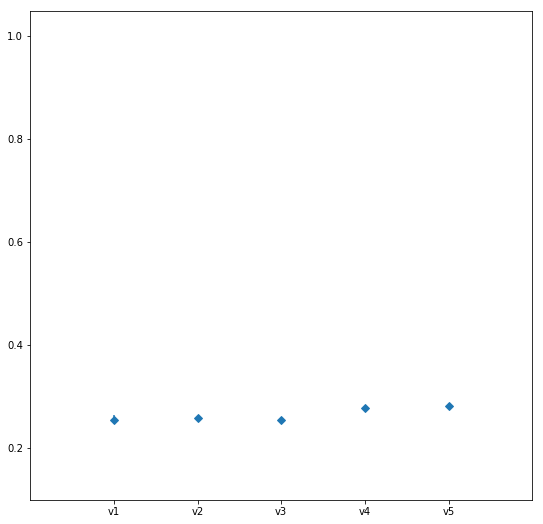

In [20]:
def create_decision_trees(X, y):
    '''Function to run all parts of DT creation and testing
    '''
    print("Decision Trees\n")

    # Make a list of trees
    trees = []
    #creates 5 different decision tree classifiers with different parameters and 
    #fits the data to them. See paper for parameter explanations
    dt = tree.DecisionTreeClassifier(criterion='entropy')
    trees.append(dt)
    dt = tree.DecisionTreeClassifier(criterion='gini')
    trees.append(dt)
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 2)
    trees.append(dt)
    dt = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 25)
    trees.append(dt)
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes = 50)
    trees.append(dt)
    
    return trees

trees = create_decision_trees(X, y)

confusionMatrix(X, y, trees[0])

# Compute cross validations for each model and print them
cvs = fiveFoldCVs(X, y, trees)
print("Confidence Intervals:")
for i in range(len(cvs)):
    print("v" + str(i) + ": ", cvs[i])
print()

# Compute p-values
getPValues(cvs)

# Create file for confidence intervals
cIPlot(cvs, 0.1)

### ANNs
After researching the neural net parameters, learnrate stood out to us as the most intriguing. We thus focused our trials on manipulating learnrate, providing two controls. We also explored more basic changes to the number of iterations and the structure of the neural net. The logic for each manipulation is as follows (parameters listed):
##### v1: (X, y, numIter=500)
Control. Default number of iterations has been raised to increase general
accuracy.
##### v2: (X, y, numIter=500, numNodes = 15, numLayers = 3)
For this manipulation, we chose to set the number of nodes to 15 and the number of hidden layers to 3. For most problems, a single hidden layer is sufficient, as the ANN weighting algorithms are complex enough that they do not need much to work with (see following versions), but we wanted to see what would happen when we set the number of layers at three, working with just the default other parameters. Theoretically, the increased complexity might increase accuracy, but it will also increase runtime.
##### v3: (X, y, numIter=500, solve = ‘sgd’)
Control (solve method). The default solver is ‘adam,’ which, according to
sklearn’s website, is “works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score.” From brief research on stack exchange, the ‘adam’ solver is actually an adaptation of the more universal stochastic gradient descent (sgd); therefore, we thought it would be interesting to compare sklearn’s default solver to the primary default solver in the field. This exploration also provides the control for our investigations of learnrate, which all require the sgd solve method.
##### v4: (X, y, numIter=500, learnRate = 'adaptive', solve = 'sgd')
The learnrate of an artificial neural net determines how quickly the ANN deserts old generalizations of the dataset for new ones. For example, suppose the ANN encounters 10 board game samples that have average playtimes of 60 minutes and have a geek rating of 5 (the highest quantile). Then suppose it encountered an 11th board game that has an average playtime of 30 minutes, but also had a geek rating of 5. If the learnrate of the ANN is relatively high, it will assume that sometimes even games with playtimes lower than 60 minutes can be rated highly; if the learnrate is relatively low, it will assume that the 11th board game is an outlier, and that only board games with playtimes of 60 minutes can be rated highly. The ‘adaptive’ parameter keeps the learnrate of the ANN at a predetermined value throughout the course of training, unless the training loss stops decreasing. If training loss ever does begin to increase, the learning rate is divided by five. The ANN should get better and better at predicting as it trains, as it learns incrementally. If this does not happen, its training loss will increase, and it will begin to “learn faster.” Since a higher learning rate means longer train time, this is one way to find an reasonable learning rate for a given data set.
##### v5: (X, y, numIter=500, learnRate = 'invscaling', solve = 'sgd')
One other possible learnrate parameter is invscaling. Invscaling works by steadily
decreasing the learning rate (roughly following exponential decay) over a time interval t. Because invscaling allows the ANN to learn very quickly initially and then more slowly as time goes on, it can provide runtime advantages without compromising accuracy  but only with static datasets . If the dataset it dynamic, and new examples are being constantly added, invscaling is a poor choice because it will not allow the ANN to update any of its initial beliefs as quickly as it should. Since our dataset is static, we should be able to appreciate an increase in runtime without a loss of accuracy by utilizing invscaling.

ANNs

Score and Confusion Matrix to illustrate problem complexity
Score:  0.309
Confusion Matrix:
 [[ 94  17  21  18  57]
 [ 77  10  18  23  66]
 [ 61  13  23  18  81]
 [ 46  12  14  22 108]
 [ 14   1  10  16 160]]

Confidence Intervals:
v0:  [ 0.294  0.28   0.313  0.318  0.317]
v1:  [ 0.309  0.277  0.32   0.311  0.306]
v2:  [ 0.204  0.193  0.187  0.18   0.184]
v3:  [ 0.204  0.193  0.187  0.182  0.184]
v4:  [ 0.204  0.193  0.187  0.22   0.221]

The p-value for 0,1 is 0.968486746913

The p-value for 0,2 is 0.000462134240533

The p-value for 0,3 is 0.000434831908457

The p-value for 0,4 is 0.000138037239823

The p-value for 1,2 is 0.000234853420856

The p-value for 1,3 is 0.000221591583612

The p-value for 1,4 is 0.000404695283501

The p-value for 2,3 is 0.3739009663

The p-value for 2,4 is 0.178239554897

The p-value for 3,4 is 0.177858401051



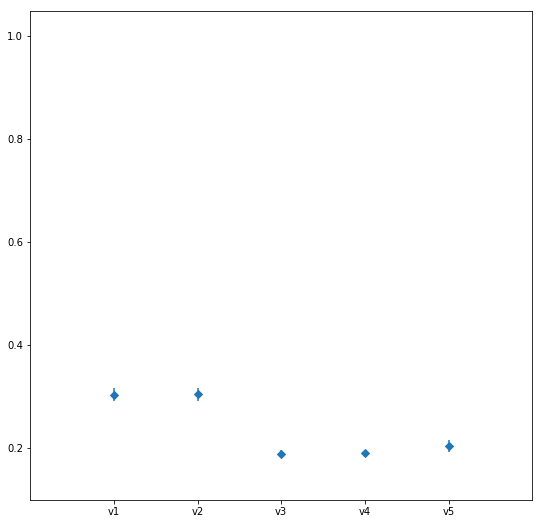

In [23]:
def makeMLP(X, y, numNodes=10, numLayers=3, numIter=200, learnRate='constant', solve='adam'):
    '''Make an ANN. Allow the number of nodes and the number of hidden layers
    and the maximum number of iterations to be set as parameters. 
    Returns the ANN.'''
    
    # Create a hidden layer tuple based on the parameters passed to the
    # function
    hiddenLayers = [numNodes for i in range(numLayers)]
    hiddenLayers = tuple(hiddenLayers)

    # Initialize ANN classifier using hiddenLayers tuple to set sizes
    ann = MLPClassifier(hidden_layer_sizes=hiddenLayers, 
                        activation='logistic',      # default is 'relu'
                        max_iter = numIter,         # default is 200
                        learning_rate = learnRate,
                        solver = solve,
                        random_state=0)             # seed
    return ann

def create_anns(X, y):
    print("ANNs\n")
    
    # Make a list of ANNs, each with a number of hidden nodes and number
    # of iterations specified in the lists "hNodes" and "maxIters" respectively
    # passed as a parameters
    anns = []

    #creates 5 artificial neural net models with 5 different sets of parameters. 
    #see paper for parameter explanations.
    ann = makeMLP(X, y, numIter = 500)
    anns.append(ann)
    ann = makeMLP(X, y, numIter = 500, numNodes = 15, numLayers = 3)
    anns.append(ann)
    ann = makeMLP(X, y, numIter = 500, solve = 'sgd')
    anns.append(ann)
    ann = makeMLP(X, y, numIter = 500, learnRate = 'adaptive', solve = 'sgd')
    anns.append(ann)
    ann = makeMLP(X, y, numIter = 500, learnRate = 'invscaling', solve = 'sgd')
    anns.append(ann)
    
    return anns

anns = create_anns(X, y)

confusionMatrix(X, y, anns[0])

# Compute cross validations for each model and print them
cvs = fiveFoldCVs(X, y, anns)
print("Confidence Intervals:")
for i in range(len(cvs)):
    print("v" + str(i) + ": ", cvs[i])
print()

# Compute p-values
getPValues(cvs)

# Create file for confidence intervals
cIPlot(cvs, 0.1)
print()

## Results
The maximum classification accuracy for all of our models and cross validations was 0.315, from v1 of our ANNs. The minimum classification accuracy was 0.18 from v3 of our ANNs. All of our classifiers have accuracies falling between this range of 0.18-0.315. Given the p-values for our decision trees, the differences between v1, v2, and v3 were not statistically significant, and the differences between v4 and v5 were also not statistically significant. However, the differences between these two groups of trees were statistically significant. Similarly, given the p-values for our ANNs, the differences between v1 and v2 were not statistically significant, and the differences between v3, v4, and v5 were also not statistically significant. However, the differences between these two groups of ANNs were statistically significant.
## Observations
None of our classifiers proved to be able to reliably classify games into the correct quantile based on the information provided to them. To be fair, the confusion matrices of both the decision trees and the ANNs show that, at the very least, the classifiers tended to be able to classify a game into a quantile close to their correct quantile. You can see this in that the values in the matrices are highest when they are closer to the central diagonal of the matrix, which represents correct classifications. This seems to indicate that somewhat good guesses can be made about a game’s overall quality based on information about its mechanics, complexity, number of players, and play time. However, given that the classifiers could not come to reliable conclusions about game quality, there are obviously other factors at play—one game with a given set of mechanics is not necessarily equal to another. Overall, among our decision trees, v4 and v5 performed the best, and their superior performance compared to v1, v2, and v3 is statistically significant. This suggests that the parameters implemented here to reduce
 overfitting were somewhat effective. Among our ANNs, v1 and v2 performed the best, and their superior performance compared to v3, v4, and v5 is statistically significant. This suggests that the default solver for sklearn’s MLPclassifier is superior compared to sgd.

The ANNs tended to classify games slightly better than the decision trees. However, ANNs being what they are, it’s difficult to parse them for information about trends in game quality. By examining leaves in the decision tree with the best performance (v5), we have attempted to arrive at some rough conclusions about general trends in game quality.
![title](https://raw.githubusercontent.com/HumbleBob/BoardGameData/master/choi.walterm.dt5.png)

The first split of the tree is “Area-Impulse<=0.5”. Not many games have the Area-Impulse mechanic, but most of the games that do are in the lower quantiles; the decision tree likely makes this the first split because it allows it to deal with a much smaller number of games on one side of the tree, where most of them can be classified relatively easily as of lower quality.

Most of the leaves where the geek_quantile values are predominantly low occur after an early split in the tree where the information gain split is “weight <= 2.6719”. This suggests that the learner identified that games in the lower percentiles of complexity often tend to be of lower quality.

The path to one leaf where 83% of games are in the 4th and 5th quantile is as follows: no Area-Impulse mechanic, weight greater than 2.6719, cooperative play mechanic, average play time greater than 97.5 minutes. Greater than 97.5 minutes average play time is typical only of games with a high degree of complexity. Furthermore, because the Area-Impulse mechanic is fairly rare, this split also does not eliminate very many games. This path suggests that games with a cooperative play mechanic, above average complexity, and average play time tend to score quite highly. If you follow the split to games with fewer than 97.5 minutes average play time, the next split is determined by whether or not the recommended age is less than 4.
 Games where the recommended age is less than 4 tend to be bad, whereas games where the recommended age is greater than 4 tend to be of high quality. All of this suggests that the learner perceived a strong correlation between cooperative play and high game quality.

One path in the tree, after following the “weight <= 2.6719” split to games with weight greater than 2.6719, consistently leads to leaves consisting primarily of games in the high quantiles. Along this path, leaves branch off from the path after being checked for particular mechanics. The first of these is point-to-point movement. The second is grid movement. The third is campaign / battle card driven. This path suggests that non-cooperative games of above average complexity, with game lengths above 42.5 minutes, so long as they possess at least one of these mechanics, tend to be of high quality.

Further trends could be ascertained by analyzing the paths of the decision tree further.
## Next Steps
Our two learning approaches with various parameters failed to create a reliable classifier for predicting the quality of a board game based upon the traits that we fed them. To provide additional information that might aid the learners, we could incorporate the “category” attribute from the raw data that was excised in our preprocessing. We would have included it, except that doing so would have ballooned our number of attributes considerably, as it would have required making each categorical value into its own boolean attribute, as we did for the “mechanics” attribute. With the addition of genre and theme information, the classifiers might be able to come to more reliable conclusions. Also, we could consider running the data through a random forest learner. The decision trees proved slightly more effective than the ANNs at classifying the board games, so using random forests to further refine the results might improve the classification rate. Finally, we could split the quantiles into more precise ranges. It could be that our quantiles are too broad (each encompassing 20% of all examples), e.g. there could be
particular qualities that are shared by games in the 75%-85% range that make it difficult to assign them to the highest or the second highest quantile. Making the quantiles more precise would reduce this problem at the risk of making the classification problem harder on average.